<div style="display:block;width:100%;margin:auto;" direction=rtl align=center><br><br>
    <div  style="width:100%;margin:100;display:block;background-color:#fff0;"  display=block align=center>
        <table style="border-style:hidden;border-collapse:collapse;">
            <tr>
                <td  style="border: none!important;">
        <img width=130 align=right src="https://i.ibb.co/yXKQmtZ/logo1.png" style="margin:0;" />
                </td>
                <td style="text-align:center;border: none!important;">
                <h1 align=center><font size=5 color="#045F5F"> <b>Deep Learning (Fall 2023)</b><br><br><b>Homework-1</i><br><br><h1><h3>Clustering with Autoencoer-Q3</i></font></h3>
                </td>
                <td style="border: none!important;">
        <img width=170 align=left  src="https://i.ibb.co/wLjqFkw/logo2.png" style="margin:0;" />
                </td>
            </tr>
        </table>
    
</div>
<br>
<font size=3 color="#045F5F">Mohammad Javad Ranjbar<br></font><br>
<font size=3 color="#045F5F">Behrad Mosaie<br></font><br>

# Required Libraries
In this code cell, we set up the necessary libraries and dependencies for knowledge distillation using a neural network. We import key libraries, including PyTorch, torchvision, and additional modules for data transformation, visualization, and progress tracking. Make sure to run this cell before proceeding with the rest of the code.



In [130]:
from sklearn import preprocessing
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score


# 1. DAC
The code defines a Deep Autoencoder Clustering (DAC) model using TensorFlow and Keras. DAC is a neural network architecture used for unsupervised clustering of data, often used in applications like image compression and feature learning. This model is designed to perform clustering on data with an encoder-decoder architecture.

Model Components:

DAC Class:
 he DAC class is defined as a subclass of tf.keras.Model. It takes three main parameters:

input_dim: The dimension of the input data.
latent_dim: The dimension of the latent space (bottleneck) where data is compressed.
num_clusters: The number of clusters, which corresponds to the output dimension of the last layer.
Encoder: The encoder is defined as a sequence of dense layers that gradually reduce the input dimension:

The first layer has 512 units and uses ReLU activation.
The second layer has 128 units with ReLU activation.
The third layer has 32 units with hyperbolic tangent (tanh) activation.
The final layer has 10 units with tanh activation.
Decoder: The decoder is defined as a sequence of dense layers that aim to reconstruct the input data from the compressed representation:

The first layer has 32 units with tanh activation.
The second layer has 128 units with tanh activation.
The third layer has 512 units with tanh activation.
The final layer has latent_dim units, which is the dimension of the latent space.

In [131]:


class DAC(tf.keras.Model):
    def __init__(self, input_dim, latent_dim, num_clusters):
        super(DAC, self).__init__()
        # Encoder
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Dense(512, activation='relu', input_shape=(input_dim,)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(32, activation='tanh'),
            tf.keras.layers.Dense(10, activation='tanh')
        ])
        # Decoder
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(32, activation='tanh', input_shape=(10,)),
            tf.keras.layers.Dense(128, activation='tanh'),
            tf.keras.layers.Dense(512, activation='tanh'),
            tf.keras.layers.Dense(latent_dim)
        ])
        # Clustering layer
        self.sigmoid1 = tf.keras.layers.Activation('sigmoid')

    def call(self, x):
        # Encoder
        encoded = self.encoder(x)
        # Decoder
        decoded = self.decoder(encoded)
        # Clustering
        outputs = self.sigmoid1(decoded)
        return outputs

# Example usage:
input_dim = 784  # For MNIST
latent_dim = 32  # You can choose an appropriate latent dimension
num_clusters = 10  # Number of clusters (output dimension of the last layer)

model = DAC(input_dim, latent_dim, num_clusters)


## Weight

The code defines a function, compute_w, which calculates a weight vector w for individual feature dimensions. These weights indicate the importance of each feature in distinguishing different clusters within a dataset. The computation method considers both the similarity of feature values within the same cluster and the dissimilarity between feature values in different clusters.

In [132]:

def compute_feature_weights(features, label, num_samples):
    num_features = features.shape[1]
    w = np.zeros((num_features,))

    for i in range(num_features):
        for j in range(num_samples):
            for k in range(num_samples):
                if label[j] == label[k]:
                    w[i] += np.exp(-((features[j, i] - features[k, i]) ** 2))
                else:
                    w[i] -= np.exp(-((features[j, i] - features[k, i]) ** 2))
    w = preprocessing.normalize([w])
    return w

In [133]:
import numpy as np
from tensorflow.keras.datasets import mnist



# Now, `random_x_train` contains 1000 random samples from the original `x_train` dataset.
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize pixel values to [0, 1]

# Reshape the data for the model
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

In [134]:
def compute_feature_weights(data, label):
    num_sampels=data.shape[0]
    num_features=data.shape[1]
    w = np.zeros(num_features)

    for i in range(num_features):
      for j in range(num_sampels):
        for k in range(num_sampels):
          if label[j] == label[k]:
            w[i] += np.exp(-(data[j,i]-data[k,i])**2)
          else:
            w[i] += 1 - np.exp(-(data[j,i]-data[k,i])**2)

    min_weight = np.min(w)
    max_weight = np.max(w)
    w = (w - min_weight) / (max_weight - min_weight)
    return w

In [135]:
input_dim = x_train.shape[1]
# Shuffle the training data
shuffled_indices = np.arange(x_train.shape[0])
np.random.shuffle(shuffled_indices)

# Get the first 500 samples (not 1000 as you mentioned in the comment)
num_samples = 100
random_x_train = x_train[shuffled_indices[:num_samples]]
random_y_train = y_train[shuffled_indices[:num_samples]]

# Calculate the weights
weights = compute_feature_weights(random_x_train, random_y_train)


In this heatmap, we visually represent the importance of features in a dataset of 500 samples. Notably, features located closer to the center of the image hold greater significance, aligning with the centrality of features in MNIST data.

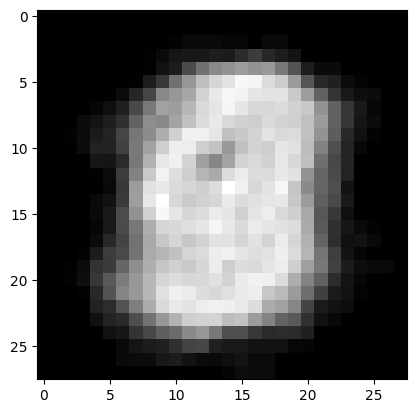

In [136]:
input_array = np.array(weights)
output_array = weights.reshape((28, 28))
plt.imshow(output_array, cmap='gray')

This Python function, clustering_weighted_mse_loss, calculates the weighted mean squared error (MSE) loss between the true values (y_true) and the predicted values (y_pred) using a set of weights (weights) that considers the most important feautres.

In [137]:
def clustering_weighted_mse_loss(y_true, y_pred,weights):
  loss = weights*((y_true - y_pred)**2)
  return tf.reduce_mean(loss)

This code initializes a DAC (Deep Autoencoder for Clustering) model with specific dimensions and number of clusters. It uses a custom loss function and the Adam optimizer for training. The training loop runs for a specified number of epochs, where data is divided into batches for training, and model weights are updated accordingly, with the loss printed at each epoch.






In [138]:

# Initialize the DAC model
input_dim = x_train.shape[1]
latent_dim = 784  # Choose an appropriate latent dimension
num_clusters = 10
model = DAC(input_dim, latent_dim, num_clusters)

# Define the loss function (e.g., mean squared error)
loss_fn = clustering_weighted_mse_loss

# Define the optimizer (e.g., Adam)
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4,weight_decay=0.00001)

# Training parameters
epochs = 50
batch_size = 64

# Training loop
for epoch in range(epochs):
    for i in range(0, len(x_train), batch_size):
        x_batch = x_train[i:i+batch_size]

        with tf.GradientTape() as tape:
            cluster_output = model(x_batch)
            loss = loss_fn(x_batch, cluster_output,weights)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    print(f"Epoch {epoch + 1}, Loss: {loss.numpy()}")




Epoch 1, Loss: 0.024853438138961792
Epoch 2, Loss: 0.01832585409283638
Epoch 3, Loss: 0.015772975981235504
Epoch 4, Loss: 0.014166552573442459
Epoch 5, Loss: 0.013006295077502728
Epoch 6, Loss: 0.01217908039689064
Epoch 7, Loss: 0.011603920720517635
Epoch 8, Loss: 0.01111545693129301
Epoch 9, Loss: 0.010699561797082424
Epoch 10, Loss: 0.010342519730329514
Epoch 11, Loss: 0.009995510801672935
Epoch 12, Loss: 0.009685509838163853
Epoch 13, Loss: 0.009424980729818344
Epoch 14, Loss: 0.009094811975955963
Epoch 15, Loss: 0.00883902981877327
Epoch 16, Loss: 0.008598150685429573
Epoch 17, Loss: 0.008371972478926182
Epoch 18, Loss: 0.008186965249478817
Epoch 19, Loss: 0.008028550073504448
Epoch 20, Loss: 0.007914967834949493
Epoch 21, Loss: 0.007810044102370739
Epoch 22, Loss: 0.007694763597100973
Epoch 23, Loss: 0.0075557418167591095
Epoch 24, Loss: 0.00740518793463707
Epoch 25, Loss: 0.007321713957935572
Epoch 26, Loss: 0.007210373878479004
Epoch 27, Loss: 0.007137961685657501
Epoch 28, Loss

In [142]:
# After training, you can use the encoder part of the model to cluster data
num_clusters=10
encoder_output = model.encoder(x_test)
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(encoder_output)
predicted_labels = kmeans.labels_
ari = adjusted_rand_score(y_test, predicted_labels)
print(f"Adjusted Rand Index: {ari}")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Adjusted Rand Index: 0.5689845557630019


In [143]:
num_clusters=10
encoder_output = model.encoder(x_train)
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(encoder_output)
predicted_labels = kmeans.labels_

ari = adjusted_rand_score(y_train, predicted_labels)
print(f"Adjusted Rand Index: {ari}")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Adjusted Rand Index: 0.5603453542532038


In [144]:
num_clusters=10
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(x_train)
predicted_labels = kmeans.labels_

ari = adjusted_rand_score(y_train, predicted_labels)
print(f"Adjusted Rand Index: {ari}")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Adjusted Rand Index: 0.3607179625149027


In [145]:
num_clusters=10
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(x_test)
predicted_labels = kmeans.labels_

ari = adjusted_rand_score(y_test, predicted_labels)
print(f"Adjusted Rand Index: {ari}")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Adjusted Rand Index: 0.38099932644261486
